# Representational Similarity Analysis

Representational Similarity Analysis (RSA) is a way to compare and contrast different brain states and quantify the space in which they are embedded. RSA is a highly versatile tool: it can be used to compare brain activity to models, compare data across brain imaging techniques, and even to make cross-species comparisions.

## Goal of this script
>Work with a new dataset  
>Learn to compute RSA on a dataset  
>Be able to read a (dis)similarity matrix


### Dataset description

The dataset we will be using for this exercise is from Kriegeskorte et al. (2008), called 'Ninetysix' in the datasets folder. 96 visual stimuli, from the 6 categories listed below, were presented to participants. The image stimuli are stored in the subfolder 'Stimuli'.

The data have 6 categories:  
    1. artificial inanimate 
    2. human bodypart 
    3. human face 
    4. natural inanimate 
    5. nonhuman bodypart
    6. nonhuman face

**Self-study:** Explore the data

In [1]:
import numpy as np
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import pandas as pd
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance

## Load the data for one subject

The data for these participants are stored as a matlab file (it was 2008 after all...). Python is able to load matlab files using a scipy utility. However, the file formats can be tricky and may require transformations to make compatible with typical Python organization. 

The data from matlab are stored as a dictionary where the variables in the matlab files are keys in the dictionary:

>The ROI names are listed in **roinames**.   
>The category label indices for each condition are listed in **labels**.   
>The label indices correspond to entries in **categoryNames**.  
>The data for each ROI, in the order of roinames, is stored in **roi_data**.  

Each row of roi_data represents a stimulus (as defined in labels) and each column represents a voxel (there will be different numbers of voxels in different ROIs). These data have been preprocessed and each entry is stored in terms of t-values. There is no time information and no baseline signal to be used for reference.

**Self-study:** What do you think these t-values reflect?

The last 4 rows of the dataset have unknown labels (dun dun dunnnnn!). We'll use only the first 92 rows for analysis, for now.

In the analyses that follow we are going to explore the data of subject 'BE'.

In [2]:
# Load the data
dir = '/gpfs/milgram/data/cmhn-s18/datasets/Ninetysix/'
subj_initials = 'BE'
data = scipy.io.loadmat(dir + subj_initials + '_roi_data.mat')  # Store the mat file as a dictionary
roi_data = data['roi_data']
roi_names = data['roinames']
labels = np.array(data['labels'])
categoryNames = data['categoryNames']
images = scipy.io.loadmat(dir + subj_initials + '_images.mat')['images']  # Store the mat file as a dictionary

<IPython.core.display.Javascript object>


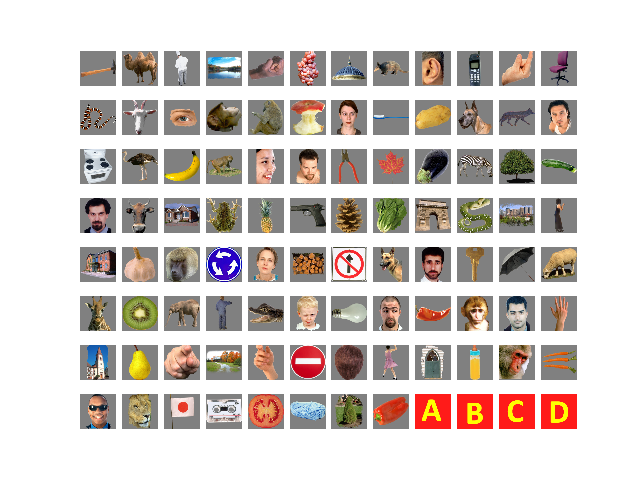

In [3]:
# Load in all of the images for this participant
plt.figure()
for image_counter in range(96):
    plt.subplot(8, 12, image_counter + 1)
    plt.imshow(images[image_counter,0])
    plt.axis('off')

In [81]:
# Load labels and ROIs
categories = [0] * categoryNames.shape[1]
for label_counter in range(categoryNames.shape[1]):
    categories[label_counter] = categoryNames[0, label_counter][0]

rois = [0] * roi_names.shape[1]
for roi_counter in range(roi_names.shape[1]):
    rois[roi_counter] = roi_names[0, roi_counter][0]    
    
# Print the labels
print('Category name:')
print(categories)

# Print the ROIs
print('ROIs:')
print(rois)


Category name:
['artificial inanimate', 'human bodypart', 'human face', 'natural inanimate', 'nonhuman bodypart', 'nonhuman face']
ROIs:
['lFFA', 'rFFA', 'lLO', 'rLO', 'lPPA', 'rPPA']


**Exercise 1:** Check to see if the right number of brain patterns were imported for each of the ROIs. Plot a histogram to show how many images there are in each category.

True


<IPython.core.display.Javascript object>


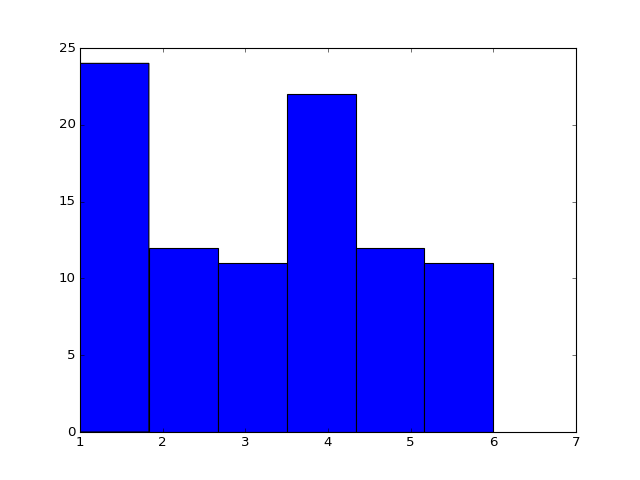

(array([ 24.,  12.,  11.,  22.,  12.,  11.]),
 array([ 1.        ,  1.83333333,  2.66666667,  3.5       ,  4.33333333,
         5.16666667,  6.        ]),
 <a list of 6 Patch objects>)

In [35]:
# Check the shape of the data to see that you have the right number of elements in each ROI

print(roi_data.shape[1] == len(rois))

# Plot a histogram to show how many images there are in each category.

labs = []
for lab_counter in range(labels.shape[0]):
    if not np.isnan(labels[lab_counter][0]):
        labs.append(int(labels[lab_counter][0]))
plt.figure()
plt.hist(labs, bins=6, range=(1,6))

In [36]:
# Extract data for a few ROIs (Left/Right FFA and PPA)
lffa_data=np.array(roi_data[0,0])
rffa_data=np.array(roi_data[0,1])
lppa_data=np.array(roi_data[0,4])
rppa_data=np.array(roi_data[0,5])

## Viewing the data

It is always a good idea to plot data as a sanity check before starting analysis. 

We also want to see the corresponding labels. Notice the category order is random.

<IPython.core.display.Javascript object>


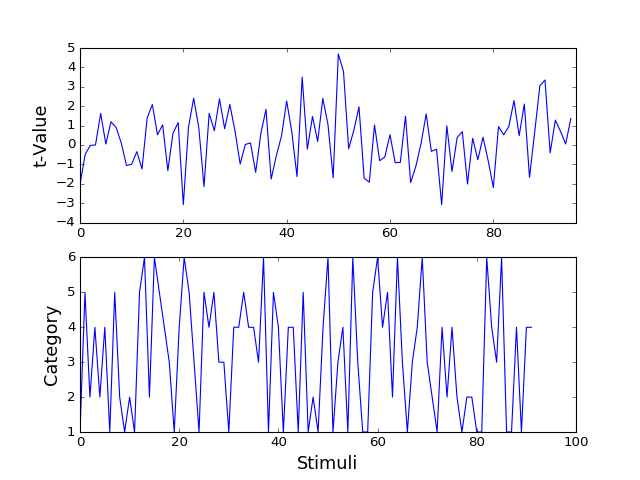

In [37]:
# Data plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(lffa_data[:, 0])  # Plot the activity per stimulus for a single voxel
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

# Label plot
plt.subplot(2,1,2)
plt.plot(labels)
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)

<IPython.core.display.Javascript object>


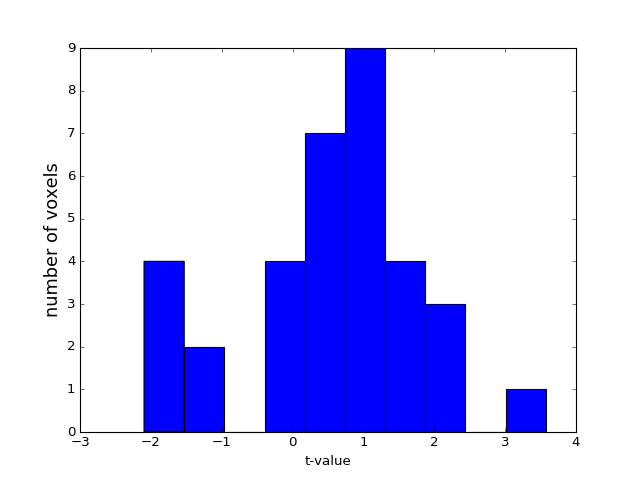

(array([ 4.,  2.,  0.,  4.,  7.,  9.,  4.,  3.,  0.,  1.]),
 array([-2.09621763, -1.52923164, -0.96224566, -0.39525967,  0.17172632,
         0.73871231,  1.3056983 ,  1.87268429,  2.43967028,  3.00665627,
         3.57364225]),
 <a list of 10 Patch objects>)

In [39]:
# Display the distribution of t values for different voxels in this ROI.
plt.figure()
plt.ylabel('number of voxels', fontsize=16)
plt.xlabel('t-value')
plt.hist(lffa_data[0, :])

## Create a similarity matrix

Let's examine the similarity of the neural representations of each image. We can look at the pattern of activity across voxels that each image evokes. We can then correlate those patterns with each other to get a matrix describing how similar they are. We only have category labels for the first 92 images, so we'll start with those.

<IPython.core.display.Javascript object>


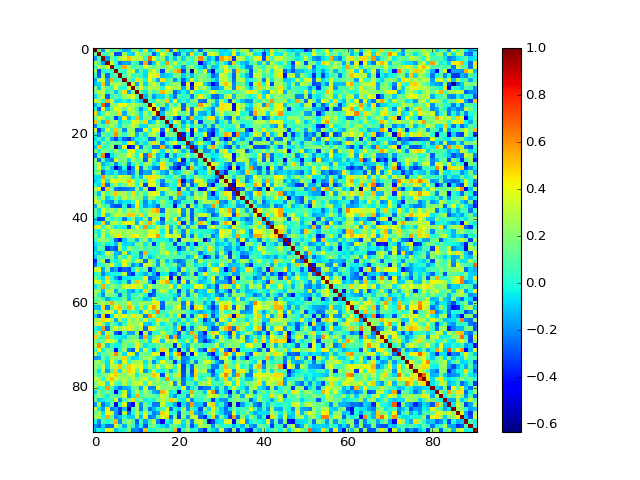

In [60]:
r = np.corrcoef(lffa_data[:92,])
plt.figure()
plt.imshow(r, cmap='jet', interpolation='none')
plt.colorbar()

**Exercise 2:** In the plot above you used Pearson correlation to compute similarity. An alternative metric is a Spearman correlation. Explain the difference and redo the analysis above with Spearman correlation.

**A:** From http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/:

The Pearson correlation evaluates the linear relationship between two continuous variables. A relationship is linear when a change in one variable is associated with a proportional change in the other variable.

The Spearman correlation evaluates the monotonic relationship between two continuous or ordinal variables. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data, which makes it ideal for ordinal data.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


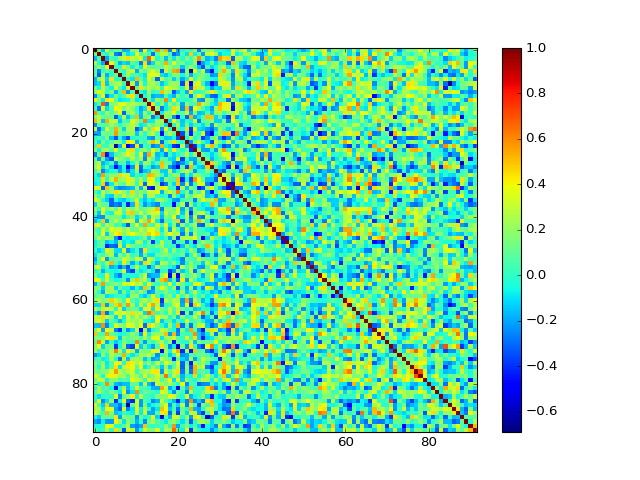

In [123]:
rho, p = scipy.stats.spearmanr(lffa_data[:92,].T)
plt.figure()
plt.imshow(rho, cmap='jet', interpolation='none')
plt.colorbar()

## Reorder the data

Although the plot above is useful, it is hard to observe any structure because the order of the stimuli is random. To simplify, let's reorganize into label groups.

[ 0 41 44 46 24 48 51 54 57 19 58 66 38 72 11 77  9  6 80 81 86 87 89 30 76
 71 63 78 79 74 47 10  2 14  4  8 29 65 52 67 70 23 56 18 84 28 36 83 75 73
  3 68 88 90 91 61  5 31 17 26 32 34 35 53 40 42 49 43 20 33  1 39 27  7 12
 59 25 62 22 16 45 13 60 55 21 64 85 82 50 69 15 37 94 92 93 95]


<IPython.core.display.Javascript object>


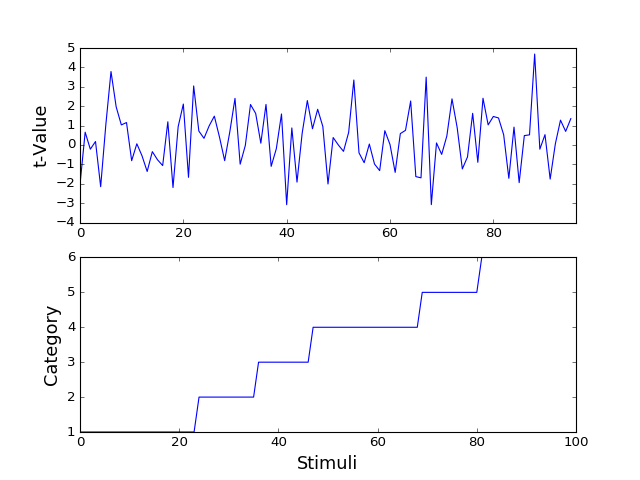

In [56]:
# Add the stimulus condition labels so that we can sort the data, collecting rows from the same condition together.
ordered_labels = labels.T.argsort().reshape(96,)
lffa_sorted = lffa_data[ordered_labels, :]

# Plot the new sorted results
plt.figure()
plt.subplot(2,1,1)
plt.plot(lffa_sorted[:,0])
plt.ylabel('t-Value', fontsize=16)
plt.xlim(0, 96)

plt.subplot(2,1,2)
plt.plot(sorted(labels))
plt.xlabel('Stimuli', fontsize=16)
plt.ylabel('Category', fontsize=16)
plt.show()

**Exercise 3:** This new organization is helpful but could be improved (based on our knowledge of the brain). Order the datapoints so that the categories are as follows: human body part, human face, non-human body part, non-human face, natural inanimate and artificial inanimate. This will make for a nicer looking correlation matrix and will help you see any structure within and between categories. Recompute the Pearson correlation similarity matrix.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


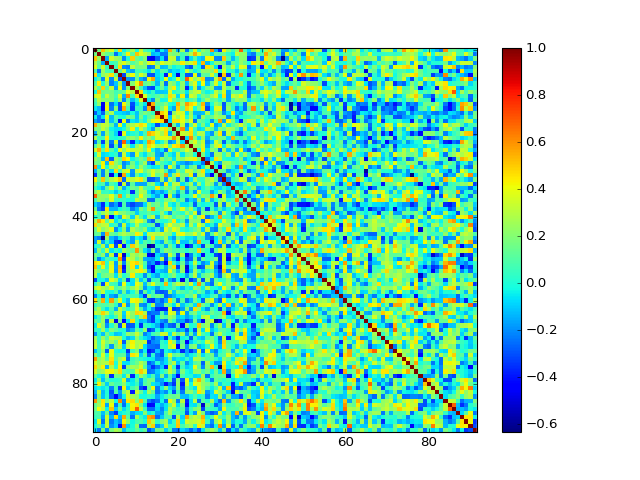

In [127]:
correct_order = [2, 3, 5, 6, 4, 1]

n_stimuli = len(labs)
mystery_inds = list(range(n_stimuli, labels.shape[0]))
#print(mystery_inds)
                 
ordered_labels = []
for cat in correct_order:
    for i in range(n_stimuli):
        if labs[i] == cat: ordered_labels.append(i)

ordered_labels = ordered_labels + mystery_inds
lffa_sorted = lffa_data[ordered_labels, :]
#print(ordered_labels)

r = np.corrcoef(lffa_sorted[:92,])
plt.figure()
plt.imshow(r, cmap='jet', interpolation='none')
plt.colorbar()

## How to read a similarity matrix

It is important to be able to read a similarity matrix at a glance. There are couple features to look out for and we will highlight these with some toy data.

Imagine a scenario where we have 12 trial types (e.g., images) grouped into 4 conditions (e.g., faces, objects, body parts, and scenes). We are going to simulate some data that has similar structure within category but different structure between categories.

<IPython.core.display.Javascript object>


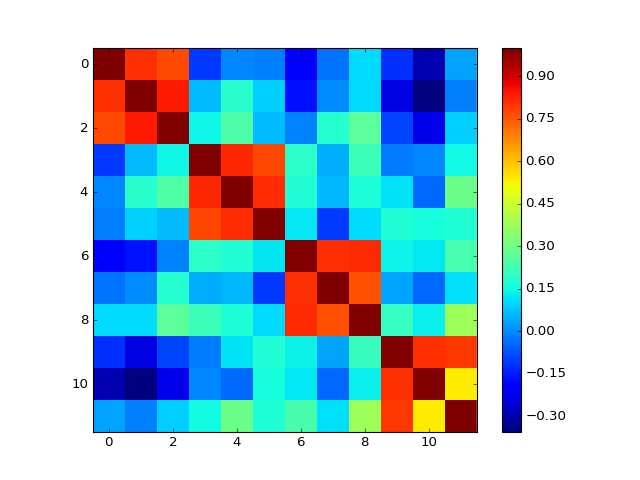

In [67]:
trial_types = 12
trial_conditions = 4
repetitions_per_trial = 24
trial_noise = 0.5
trials_per_condition = int(trial_types / trial_conditions)

# The template per category
category_templates = np.random.randn(trial_conditions, repetitions_per_trial)

# Create the trial activity
trials = np.zeros((trial_types, repetitions_per_trial))
for condition_counter in range(trial_conditions):
    condition_trials = np.random.randn(trials_per_condition, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_condition):
        trials[(trials_per_condition * condition_counter) + trial_counter, :] = category_templates[condition_counter, :] + condition_trials[trial_counter, :]

# Create the correlation matrix    
sim_r1 = np.corrcoef(trials)
plt.figure()
plt.imshow(sim_r1, interpolation='none', cmap='jet')
plt.colorbar()

In the above plot you should see some clear blocking structure along the diagonal: items within a category are more similar to one another than they are to items in different categories.

Below we create a plot where there is off-diagonal structure. High similarity in off-diagonal parts of a similarity matrix means that elements that are far apart in the ordering have similar structure. In this toy simulation we create an example where the first and third categories are similar to one another (i.e., faces and body parts).

<IPython.core.display.Javascript object>


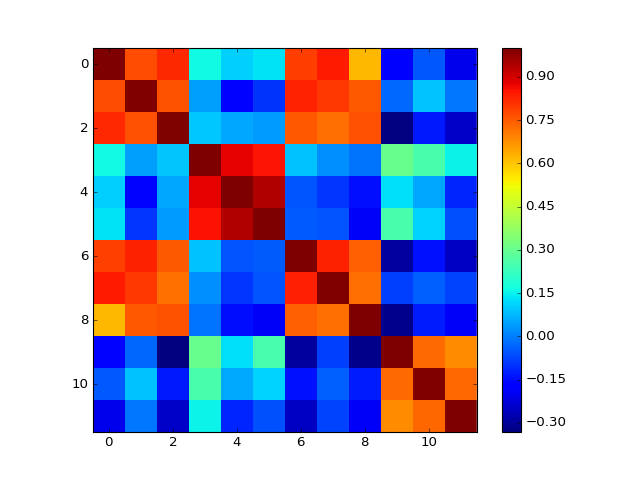

In [68]:
# Overwrite the template for the 3rd category with the template for 1st category
category_templates[2, :] = category_templates[0, :]

# Create the trial activity
trials = np.zeros((trial_types, repetitions_per_trial))
for condition_counter in range(trial_conditions):
    condition_trials = np.random.randn(trials_per_condition, repetitions_per_trial) * trial_noise
    for trial_counter in range(trials_per_condition):
        trials[(trials_per_condition * condition_counter) + trial_counter, :] = category_templates[condition_counter, :] + condition_trials[trial_counter, :]

# Create the correlation matrix    
sim_r2 = np.corrcoef(trials)
plt.figure()
plt.imshow(sim_r2, interpolation='none', cmap='jet')
plt.colorbar()

**Exercise 4:** Now use your new knowledge about reading a similarity matrix to interpret the matrix you created for the real data.

**A:** There are several structural elements in the matrix above. There is higher similarity on the diagonal for elements 1-44 and then for 45-92. The first chunk corresponds to the categories 'human bodypart', 'human face', and 'nonhuman bodypart'. The second corresponds to 'nonhuman face', 'natural inanimate', 'artificial inanimate'. This suggests that bodyparts and human faces are represented similarly in left FFA, as are non-human faces and inanimate objects.

There is also some negative correlation off the diagonal. This appears to run between the second two categories in each of the three-category groupings above. That is, the responses to 'human face' and 'nonhuman bodypart' are negatively correlated with the responses to 'natural inanimate' and 'artifical inanimate', indicating a high degree of dissimilarity.

**Exercise 5:** The previous analyses framed everything in terms of similarity between the items. However people sometimes prefer to consider this type of data in terms of dissimilarity. This close cousin of the similarity matrix is called the representational dissimilarity matrix (RDM). The dissimilarity matrix is computed simply as 1 - correlation. Plot the RDM for the right FFA ROI.

<IPython.core.display.Javascript object>


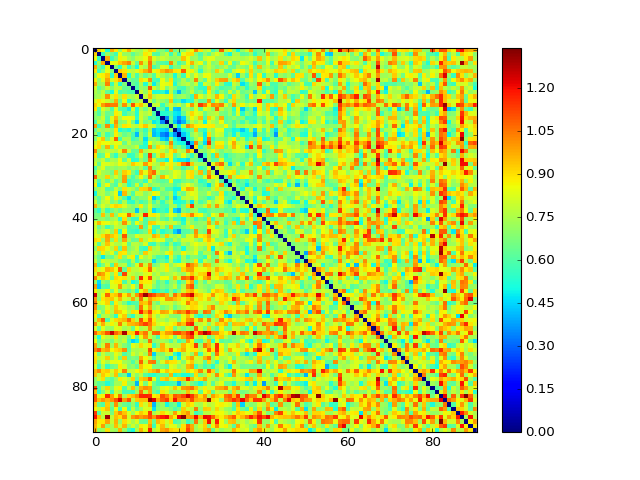

In [73]:
rffa_sorted = rffa_data[ordered_labels, :]
#print(ordered_labels)

diff = 1 - np.corrcoef(rffa_sorted[:92,])
plt.figure()
plt.imshow(diff, cmap='jet', interpolation='none')
plt.colorbar()

**Exercise 6:** For RDM plots based on correlation values, what does an RDM value greater than 1 correspond to in terms of a correlation?

**A:** An RDM *dis*similarity value greater than 1 just means that the initial correlation was negative.

## Manifolds and multi-dimensional scaling (MDS)

The correlation matrix for the 92 images describes how similar each item is to each other item. This means that if two items have a high positive correlation then they can be thought of as eliciting a very similar activation pattern across voxels. We can reframe this to be thought of as a distance in a high-dimensional space. From this perspective, items that are similar to one another will be grouped close together and far away from points that they are dissimilar to. 

Multi-Dimensional Scaling (MDS) allows us to visualize precisely the similarity of our data. There is a built-in method in scikit-learn [here](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling). More information about the method may also be accessed [here](https://homepages.uni-tuebingen.de/florian.wickelmaier/pubs/Wickelmaier2003SQRU.pdf)

In [128]:
#Create a 2-D MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
results = mds.fit(1 - r)  # Use the similarity matrix

**Exercise 7:** How does changing the order of the data (e.g., shuffling the rows/columns) in your RDM affect the distance between points calculated by MDS?

**A:** Shuffling should *not* affect the distance between points, because it changes only the order of the points, and not their locations.

## Plot the 2D structure of the RDM

We'll plot the 92 images on a "map" signifying how close or far apart images are to each other. We use different colors for the 6 categories of images.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


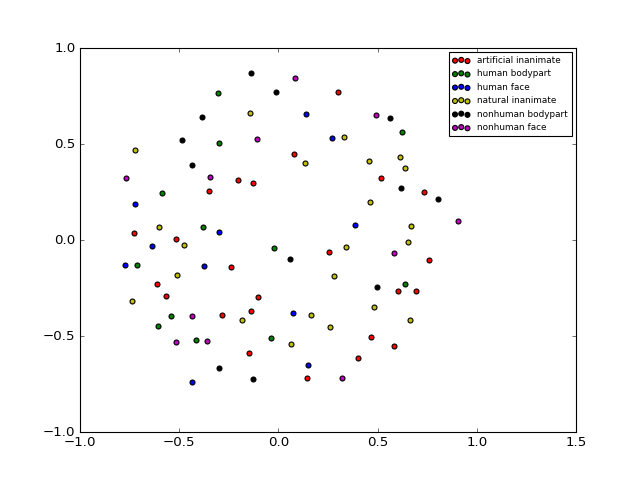

In [129]:
coords = results.embedding_

plt.figure()
color_list = ['r', 'g', 'b', 'y', 'k', 'm']
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:,0]
    plt.scatter(
        coords[label_idxs, 0], coords[label_idxs, 1], marker = 'o', c=color_list[int(label_counter - 1)]
        )

plt.legend(categories, prop={'size': 8})

**Self-study**: On the MDS plot you are currently plotting each item is a point. You could instead load in each image and plot that image on the MDS plot directly to get a feel for what images are being grouped.

## Plot the 3D structure of the RDM

MDS is just trying to find a k-dimensional embedding that minimizes the stress (something akin to the goodness of fit). This means we can actually plot it in arbitrarily high dimensions to try and capture the data structure. Below we make a 3D plot.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


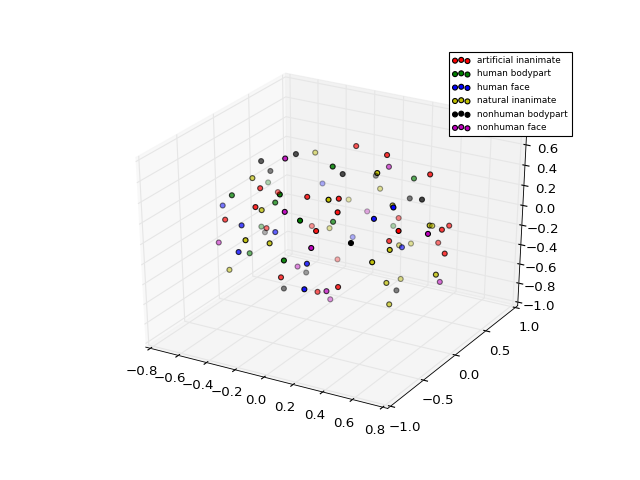

In [130]:
#Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(1 - r)

coords = results.embedding_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:,0]
    ax.scatter(coords[label_idxs, 0], coords[label_idxs, 1], coords[label_idxs, 2], marker = 'o', c=color_list[int(label_counter - 1)]
        )
plt.legend(categories, prop={'size': 8})

There are tools available to us to evaluate what is the appropriate dimensionality for visualization of our data (i.e. what dimensionality has sufficiently low stress). We can look at the stress of the MDS with different numbers of components (i.e. different dimensionality) and determine what dimensionality of the data is appropriate.

Let's make a toy problem to start off with in order to get a handle on what this should look like. We are going to make points that lie on a line in 3 dimensional space. Because a line has only one dimension of information (along its length) the data ought to be able to be reduced in dimensionality to a single dimension. We will run MDS on this data to see if that is the case.

<IPython.core.display.Javascript object>


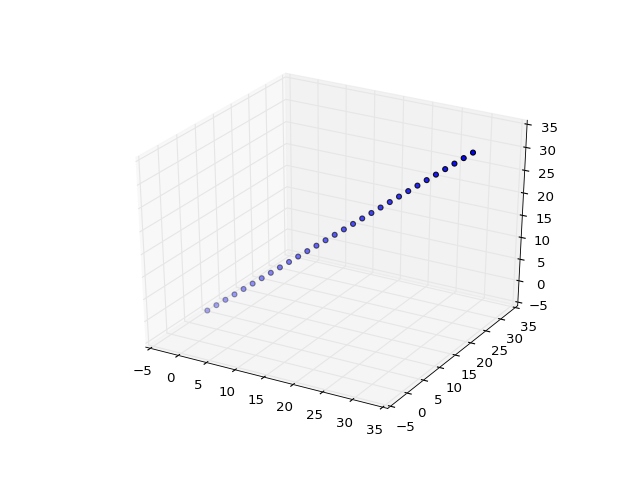

In [84]:
coords = np.linspace(1, 30, 30)
coords = np.vstack((coords, coords, coords)).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])

<IPython.core.display.Javascript object>


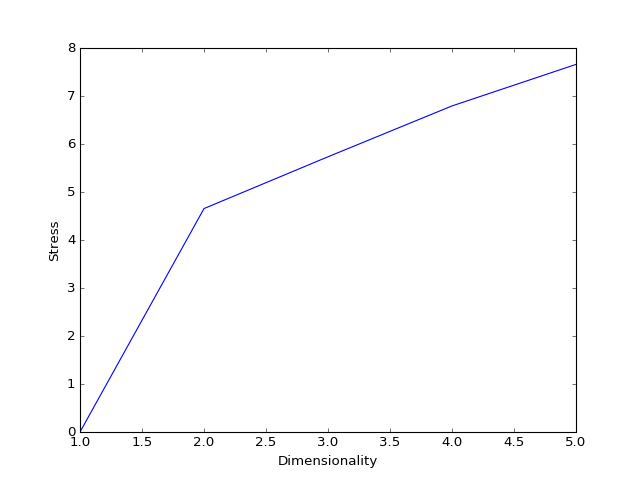

In [85]:
# Calculate the euclidean distance of every point from every other point
dist = sp_distance.squareform(sp_distance.pdist(coords))

# Iterate through different numbers of components
stress = [0] * 5
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    
    # Pull out the stress of the MDS fit
    stress[components - 1] = mds.fit(dist).stress_

# Plot the stress
plt.figure(); 
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')

**Exercise 8:** It is not typical for data to be able to be described accurately in low dimensionality: stress generally decreases with the number of components. Perform a similar analysis below to estimate the appropriate dimensionality to visualize the RDM of the left FFA data from this participant.

<IPython.core.display.Javascript object>


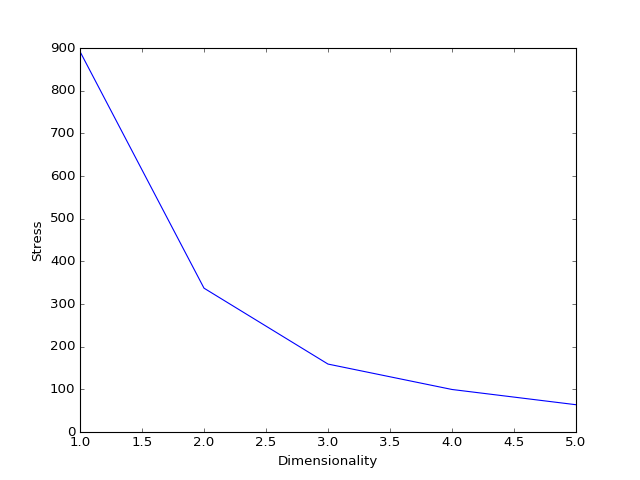

In [86]:
# Iterate through different numbers of components
stress = [0] * 5
for components in range(1, 6):
    mds = MDS(n_components=components, dissimilarity="precomputed", random_state=0)
    
    # Pull out the stress of the MDS fit
    stress[components - 1] = mds.fit(1 - r).stress_

# Plot the stress
plt.figure(); 
plt.plot(range(1, 6), stress)
plt.ylabel('Stress')
plt.xlabel('Dimensionality')

**Exercise 9:** Compute RDMs and create MDS plots for the left PPA and right PPA.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


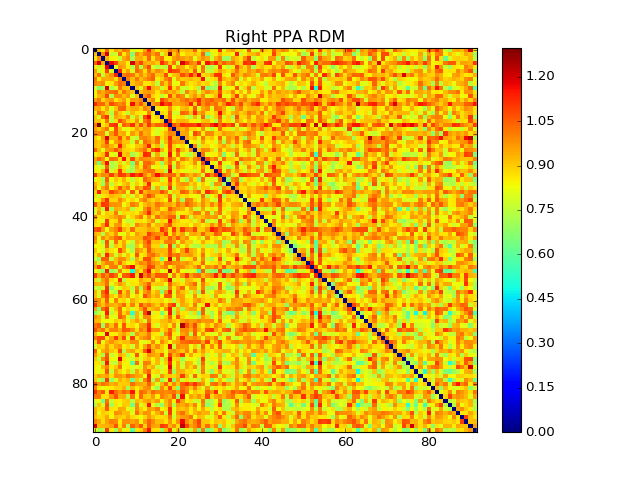

<IPython.core.display.Javascript object>


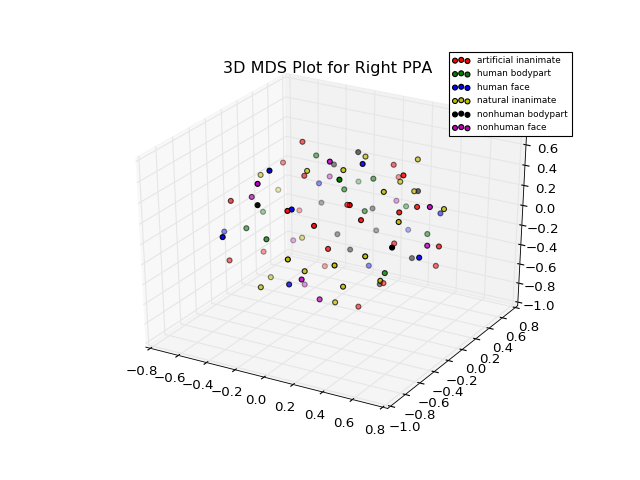

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 92 but corresponding boolean dimension is 91


In [125]:
rppa_sorted = rppa_data[ordered_labels, :]
#print(ordered_labels)

rppa_diff = 1 - np.corrcoef(rppa_sorted[:92,])

plt.figure()
plt.title('Right PPA RDM')
plt.imshow(rppa_diff, cmap='jet', interpolation='none')
plt.colorbar()

#Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(rppa_diff)

coords = results.embedding_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:91] == label_counter)[:,0]
    ax.scatter(coords[label_idxs, 0], coords[label_idxs, 1], coords[label_idxs, 2], marker = 'o', c=color_list[int(label_counter - 1)]
        )
plt.legend(categories, prop={'size': 8})
plt.title('3D MDS Plot for Right PPA')

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


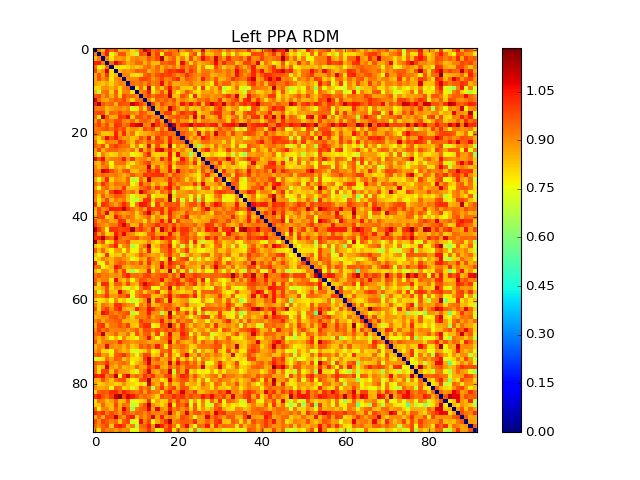

<IPython.core.display.Javascript object>


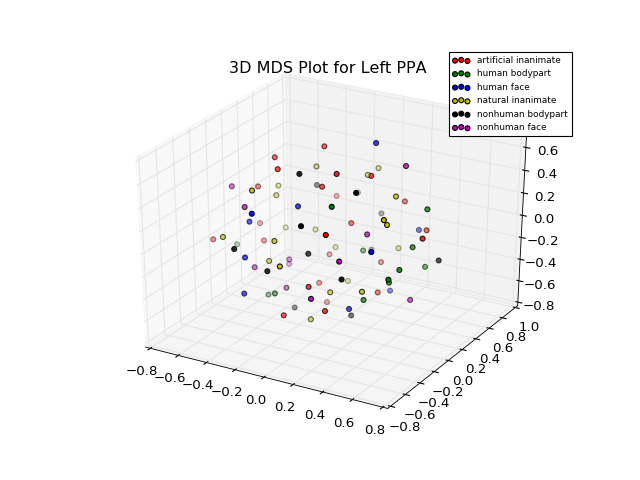

In [126]:
lppa_sorted = lppa_data[ordered_labels, :]
lppa_diff = 1 - np.corrcoef(lppa_sorted[:92,])

plt.figure()
plt.title('Left PPA RDM')
plt.imshow(lppa_diff, cmap='jet', interpolation='none')
plt.colorbar()

#Multi-dimensional scaling
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
results = mds.fit(lppa_diff)

coords = results.embedding_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for label_counter in np.unique(labels[:92]):
    label_idxs = (labels[:92] == label_counter)[:,0]
    ax.scatter(coords[label_idxs, 0], coords[label_idxs, 1], coords[label_idxs, 2], marker = 'o', c=color_list[int(label_counter - 1)]
        )
plt.legend(categories, prop={'size': 8})
plt.title('3D MDS Plot for Left PPA')


**Exercise 10:** The last four rows in the dataset for subject BE have unmarked labels. One of them is a human face. Using the techniques outlined here and your knowledge of the brain regions -- LOC, PPA, and FFA, analyze the data make a best guess of which one of the 4 data points is a human face. Show your work and reasoning that led you to this conclusion. Hint: It would really help you to be able to visualize these 4 points amongst the points you already have.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


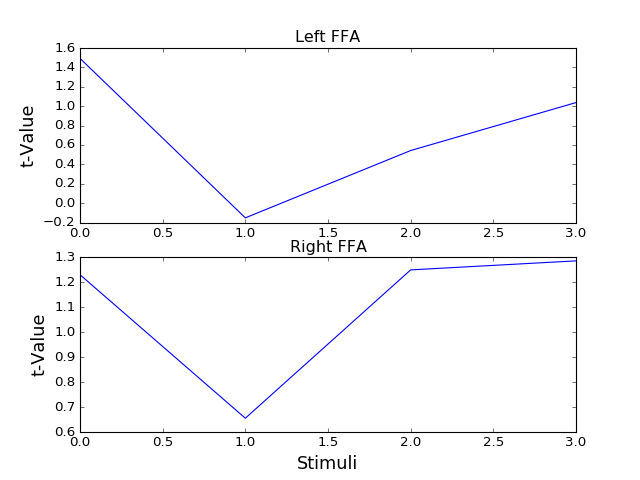

<IPython.core.display.Javascript object>


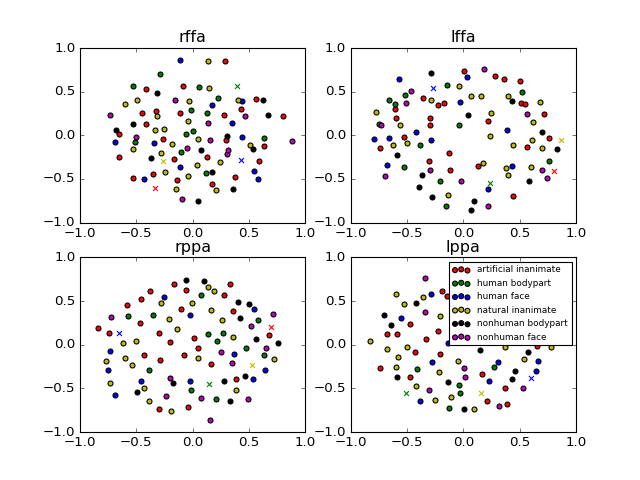

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 96 but corresponding boolean dimension is 91


<IPython.core.display.Javascript object>


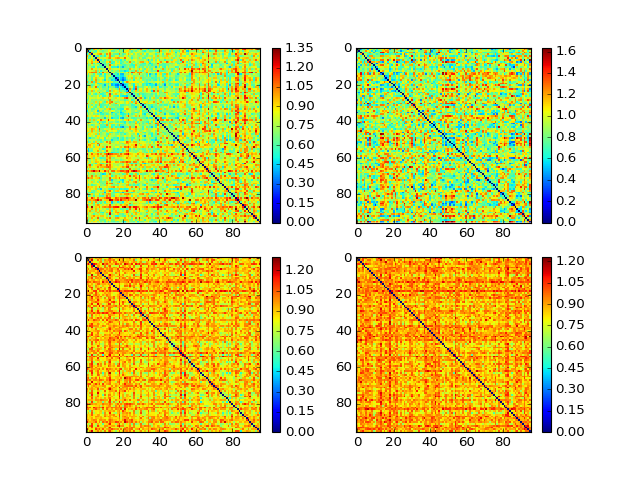

In [116]:
#first, just look at t-value data

# Data plot
mean_left = np.mean(lffa_data[92:96, :], axis=1)
mean_right = np.mean(rffa_data[92:96, :], axis=1)

plt.figure()

plt.subplot(2,1,1)
plt.title('Left FFA')
plt.plot(mean_left)  # Plot the mean activity
plt.ylabel('t-Value', fontsize=16)
#plt.xlim(92, 96)

# Label plot
plt.subplot(2,1,2)
plt.title('Right FFA')
plt.plot(mean_right)  # Plot the mean activity
plt.ylabel('t-Value', fontsize=16)
#plt.xlim(92, 96)

plt.xlabel('Stimuli', fontsize=16)

# Now, do a more complicated analysis where we do MDS on all of the data

rffa_diff = 1 - np.corrcoef(rffa_sorted[:,])
lffa_diff = 1 - np.corrcoef(lffa_sorted[:,])
rppa_diff = 1 - np.corrcoef(rppa_sorted[:,])
lppa_diff = 1 - np.corrcoef(lppa_sorted[:,])

diffs = [rffa_diff, lffa_diff, rppa_diff, lppa_diff]
titles = ['rffa', 'lffa', 'rppa', 'lppa']

plt.figure()
j = 1

for entry in diffs:
    
    plt.subplot(2, 2, j)
    plt.title(titles[j-1])
    
    #Create a 2-D MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)  # Create the MDS object
    results = mds.fit(entry)  # Use the similarity matrix

    coords = results.embedding_

    color_list = ['r', 'g', 'b', 'y', 'k', 'm']
    for label_counter in np.unique(labels[:92]):
        label_idxs = (labels[:92] == label_counter)[:,0]
        plt.scatter(
            coords[label_idxs, 0], coords[label_idxs, 1], marker = 'o', c=color_list[int(label_counter - 1)]
            )

    i = 0
    for pt in mystery_inds:
        plt.scatter(
            coords[pt, 0], coords[pt, 1], marker = 'x', c=color_list[i]
        )
        i += 1
        
    j += 1

plt.legend(categories, prop={'size': 8})

#since we can, also compute the full RDMs
plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(rffa_diff, cmap='jet', interpolation='none')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(lffa_diff, cmap='jet', interpolation='none')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(rppa_diff, cmap='jet', interpolation='none')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(lppa_diff, cmap='jet', interpolation='none')
plt.colorbar()

**A:** On the basis of the above data, especially the mean activations in PPA, I think that the human face corresponds to mystery stimulus A (that is, index 92 in the original data set). This is because it has high activation in both FFAs.

**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.

/nexsan/apps/hpc/Langs/Python/3.5-anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


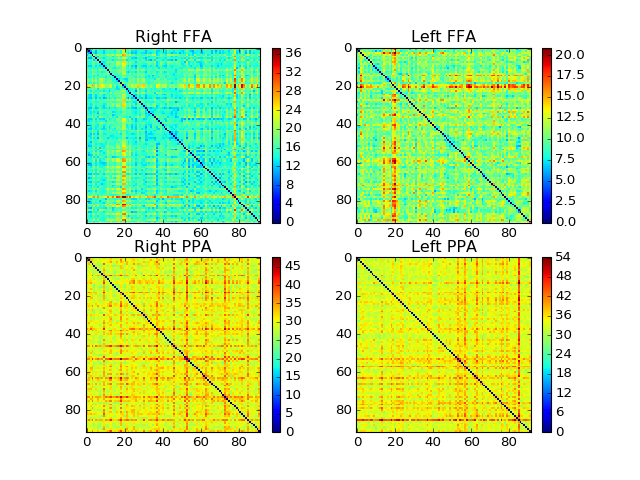

In [134]:
# Let's see what happens to the RDMs when we use Euclidean distance instead of correlation distance

from sklearn.metrics import pairwise

rffa_diff = pairwise.euclidean_distances(rffa_sorted[:92,])
lffa_diff = pairwise.euclidean_distances(lffa_sorted[:92,])
rppa_diff = pairwise.euclidean_distances(rppa_sorted[:92,])
lppa_diff = pairwise.euclidean_distances(lppa_sorted[:92,])

plt.figure()

plt.subplot(2, 2, 1)
plt.title('Right FFA')
plt.imshow(rffa_diff, cmap='jet', interpolation='none')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Left FFA')
plt.imshow(lffa_diff, cmap='jet', interpolation='none')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Right PPA')
plt.imshow(rppa_diff, cmap='jet', interpolation='none')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Left PPA')
plt.imshow(lppa_diff, cmap='jet', interpolation='none')
plt.colorbar()

These plots differ interestingly from the correlation distances. Certain stimuli (e.g. index 19 in the sorted data set) differ greatly from the rest of the population in FFA. Meanwhile, right PPA shows large differences across many different stimuli, as reflected in the red bands running vertically and horizontally. However, these distance metrics appear to have less category-based structure (as seen by the lack of square patterns either on or off the diagonal) relative to correlation distance. This makes correlation distance a better metric for our purposes here.

In terms of commonalities between the two distance metrics, differences are larger in the PPA compared to the FFA on both metrics.